In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal
from skimage import measure

%matplotlib inline

In [2]:
# cv2.__version__

## Read in and Save image

In [40]:
image = cv2.imread('Manual-Window1-Top-CMix0-0516085358.Jpeg',0) #0 for grayscale

In [ ]:
cv2.namedWindow('image', cv2.WINDOW_NORMAL) #we can resize window, default is cv2.WINDOW_AUTOSIZE
cv2.imshow('image', img) #plot image

"""
k = cv2.waitKey(0) & 0xFF #keyboard binding function: wait for the specified miliseconds for any keyboard event

if k == 27: #wait for ESC key to exit
    cv2.destroyAllWindows() #destroy all the windows we created. For specific window, use cv2.destroyWindow()
elif k == ord('s'): #wait for 's' key to save and exit
    cv2.imwrite('img1.png', img)
    cv2.destroyAllWindows()
"""

cv2.waitKey(0) & 0xFF
# cv2.destroyAllWindows()
cv2.destroyAllWindows()

## Geometric transformation of images

In [41]:
res = cv2.resize(image,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC) #shrink

In [42]:
rows,cols = img.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1) #rotate 90 degrees
dst = cv2.warpAffine(image,M,(cols,rows)) 

In [43]:
M = np.float32([[1,0,200],[0,1,200]])  #shift
dst2 = cv2.warpAffine(image,M,(cols,rows)) 

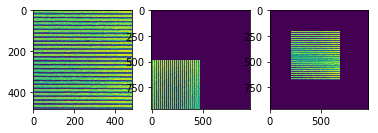

In [44]:
plt.subplot(131);plt.imshow(image) 
plt.subplot(132);plt.imshow(dst) 
plt.subplot(133);plt.imshow(dst2)
plt.show()

In [47]:
res.shape

(240, 240)

In [48]:
res[200,0], image[400,0]

(37, 30)

## Image Thresholding

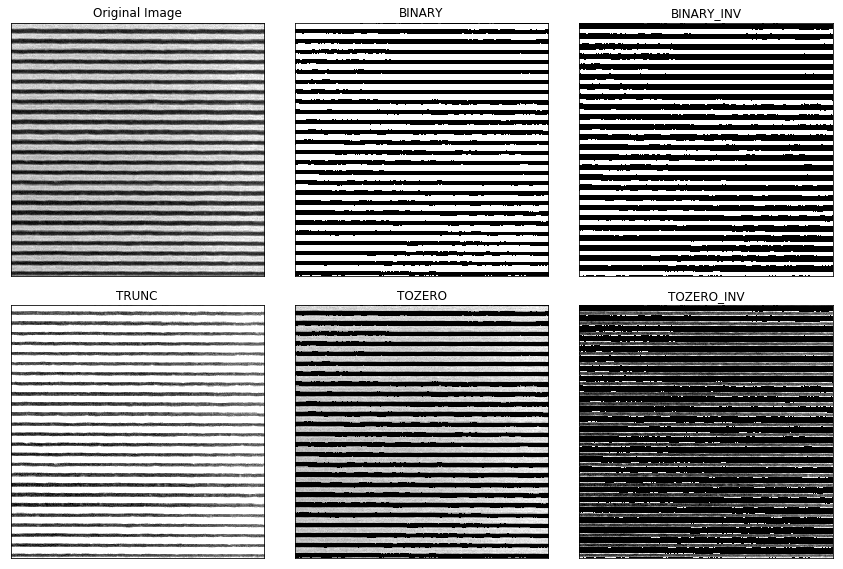

In [49]:
# Simple thresholding: single threshold for entire image

ret,thresh1 = cv2.threshold(image,128,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(image,128,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(image,128,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(image,128,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(image,128,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]

f,axarr = plt.subplots(2,3,figsize=(12,8))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

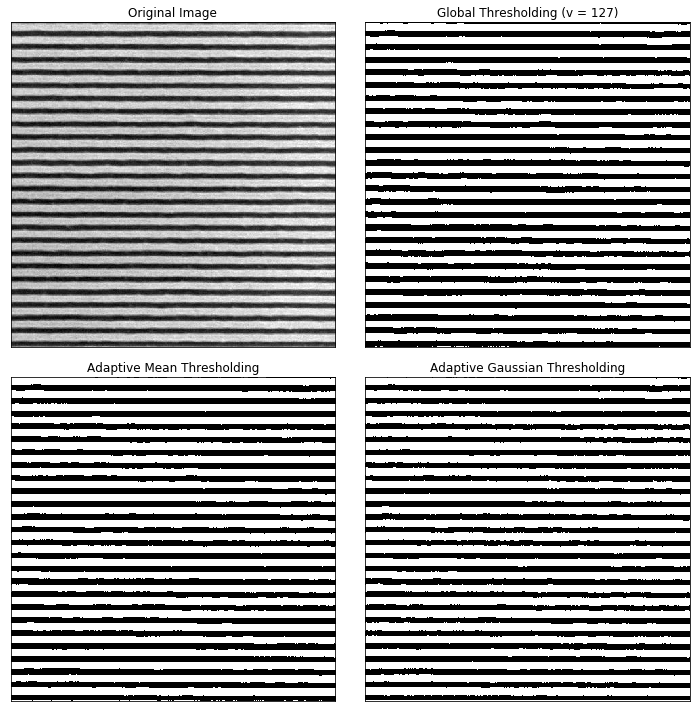

In [50]:
# Adaptive thresholding: threshold in a small region

ret,th1 = cv2.threshold(image,144,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,27,2)
th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,27,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, th1, th2, th3]

f,axarr = plt.subplots(figsize=(10,10))

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

In [42]:
th3.shape

(960, 960)

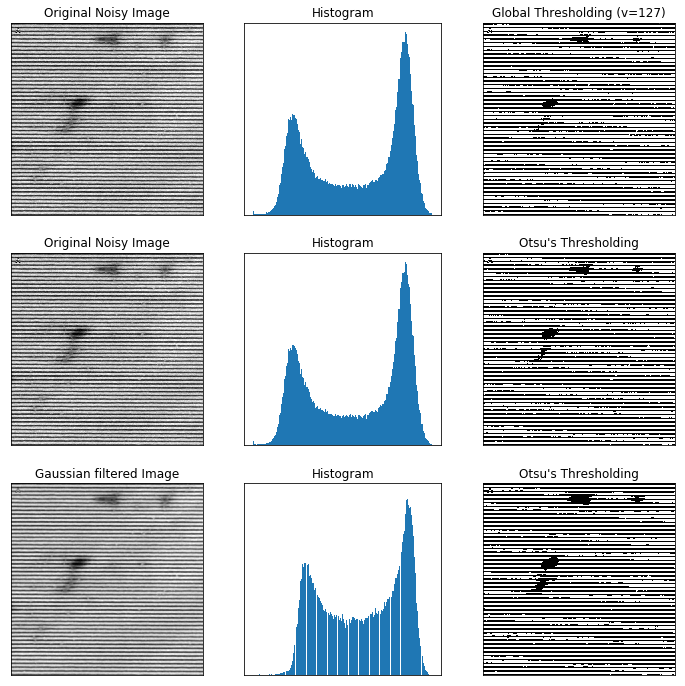

In [122]:
# Otsu's Binarization: It automatically calculate the threshold from the image

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #cv2.THRESH_BINARY+cv2.THRESH_OTSU

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

f,axarr = plt.subplots(3,3,figsize=(12,12))

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [123]:
print (ret2, ret3)

140.0 144.0


In [55]:
blur = cv2.GaussianBlur(img,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print (thresh, ret)

129 128.0


/Users/hechaoli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/hechaoli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/Users/hechaoli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


## Smoothing Images

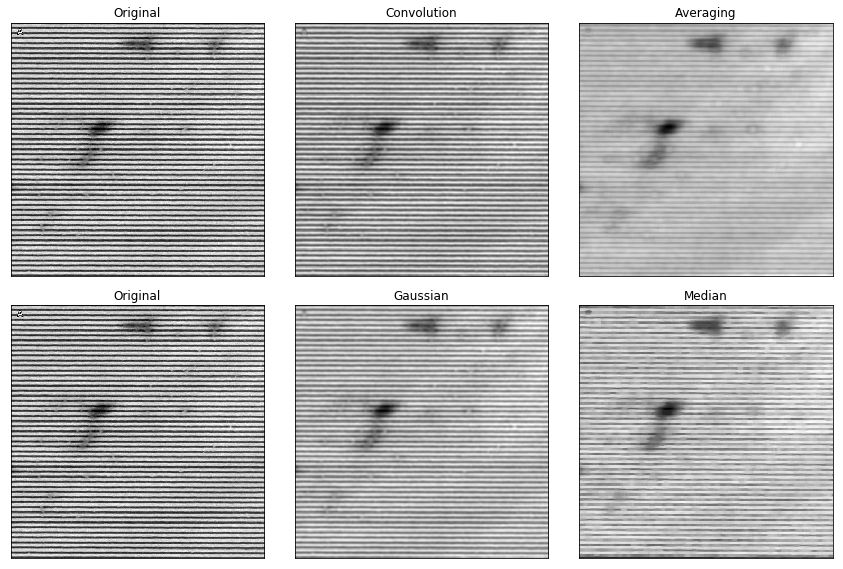

In [125]:
#Convolution
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

#Averaging
blur1 = cv2.blur(img,(11,11))

#Gaussian
blur2 = cv2.GaussianBlur(img,(11,11),0)

#Median
blur3 = cv2.medianBlur(img,11)

titles = ['Original', 'Convolution', 'Averaging', 'Original', 'Gaussian', 'Median']
images = [img, dst, blur1, img, blur2, blur3]
f,axarr = plt.subplots(2,3,figsize=(12,8))

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

## Morphological Transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x1263a8898>,
 <matplotlib.image.AxesImage at 0x12e871dd8>)

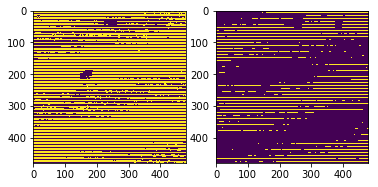

In [126]:
# Erosion

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(thresh1, kernel, iterations=1)
plt.subplot(1,2,1), plt.imshow(thresh1)
plt.subplot(1,2,2), plt.imshow(erosion)

(<matplotlib.axes._subplots.AxesSubplot at 0x123836128>,
 <matplotlib.image.AxesImage at 0x1239aad30>)

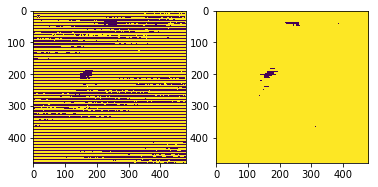

In [127]:
# Dilation

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thresh1, kernel, iterations=1)
plt.subplot(1,2,1), plt.imshow(thresh1)
plt.subplot(1,2,2), plt.imshow(dilation)

## Gradient

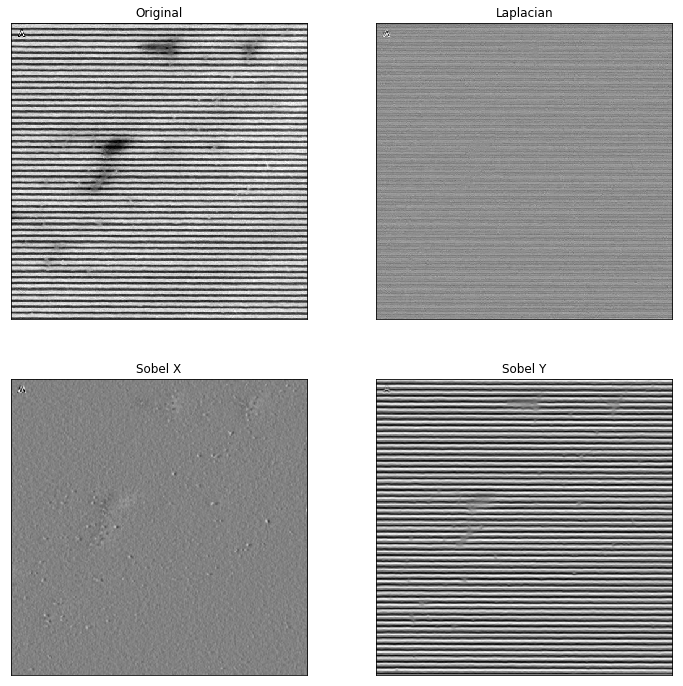

In [128]:
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

f, arr = plt.subplots(2,2, figsize=(12,12))

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

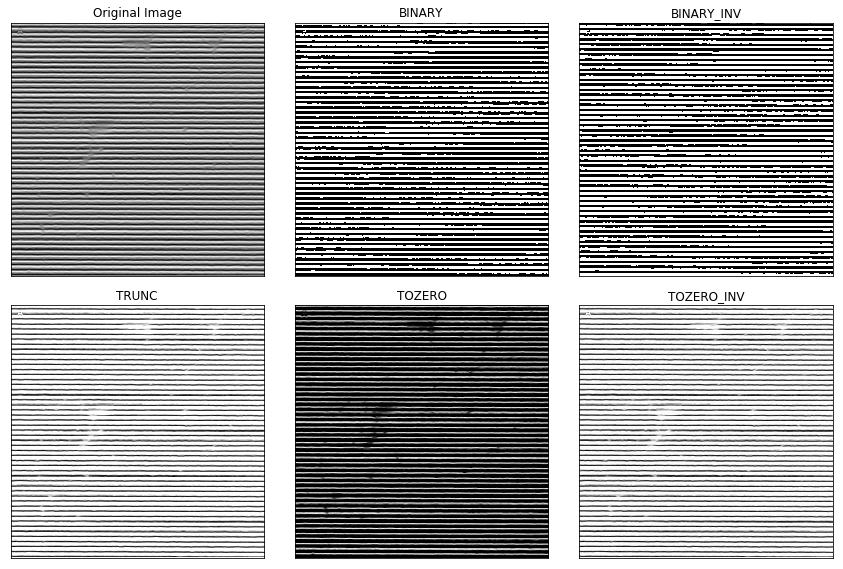

In [130]:
# try threshold after Sobel Y
ret,thresh1 = cv2.threshold(sobely,128,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(sobely,128,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(sobely,128,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(sobely,128,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(sobely,128,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [sobely, thresh1, thresh2, thresh3, thresh4, thresh5]

f,axarr = plt.subplots(2,3,figsize=(12,8))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

## Canny Edge Detection

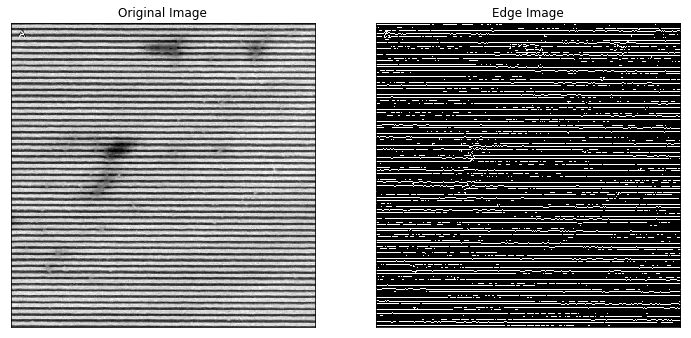

In [129]:
edges = cv2.Canny(img,100,200)

f, arr = plt.subplots(1,2, figsize=(12,12))

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Template Matching

In [3]:
image1 = cv2.imread('Manual-Window1-Top-CMix0-0516085358.Jpeg',0) #0 for grayscale

In [3]:
raw_image = cv2.resize(image1, (480,480))
width, height = raw_image.shape
ret,thresh1 = cv2.threshold(raw_image,128,1,cv2.THRESH_BINARY) #binary threshold
blur = cv2.GaussianBlur(raw_image,(5,5),0)
ret3,thresh3 = cv2.threshold(blur,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)  #Otsu's thresholding

(<matplotlib.axes._subplots.AxesSubplot at 0xa952be0>,
 <matplotlib.image.AxesImage at 0xa9cee80>)

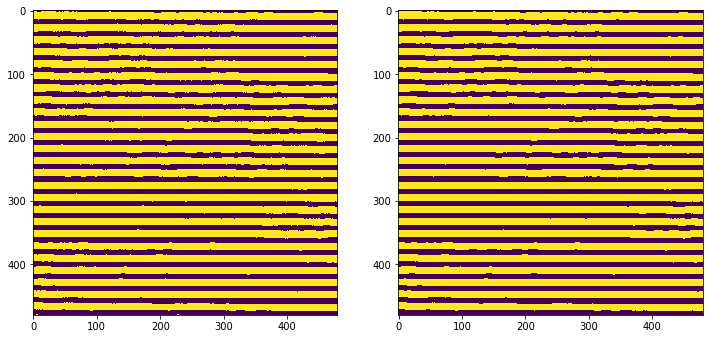

In [4]:
f,axarr = plt.subplots(1,2,figsize=(12,8))
plt.subplot(121), plt.imshow(thresh1)
plt.subplot(122), plt.imshow(thresh3)

In [5]:
print(thresh1[:,2])

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [136]:
# Generate templates for good stripe
# Then any window has a score below predefined threshold value is a defect location
# Then we can decide what kind of defect it is

#First, load a reference image to generate the template
FOV = float(input("Enter FOV in nm:"))
Width = float(input("Enter line width in nm (integer):"))
Dist = float(input("Enter line distance in nm (interger)"))
print(FOV, Width, Dist)

Enter FOV in nm:480
Enter line width in nm (integer):12
Enter line distance in nm (interger)10
480.0 12.0 10.0


In [137]:
print(width, height)

480 480


In [138]:
#pixel size in nm
pixel = FOV/width
print(pixel)

1.0


In [139]:
# line width and line distance in # of pixels
line_width = int(Width/pixel)
line_dist = int(Dist/pixel)
print(line_width, line_dist)

12 10


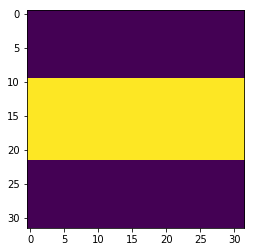

In [140]:
# generate the template with given line width and distance
arr_width = 1*line_width + 2*line_dist
arr_height = arr_width
arr = np.zeros(shape=(arr_width, arr_height))

for i in range(0,line_width):
    for j in range(0, arr_width):
        arr[line_dist+i][j] = 1
        
plt.imshow(arr)

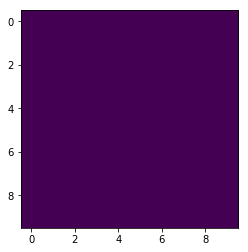

In [141]:
arr2 = np.ones(shape=(line_dist, line_dist))
plt.imshow(arr2)

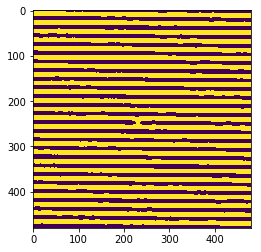

In [142]:
plt.imshow(thresh3)

In [143]:
line1 = np.ones(shape=(1,10))
line2 = np.ones(shape=(2*line_dist+line_width,1))

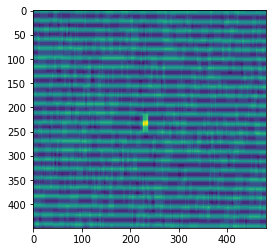

In [144]:
f = signal.convolve2d(thresh3, line2, 'valid')

plt.imshow(f)

In [145]:
#print(f[:,230])
np.min(f)

12.0

In [146]:
np.max(f)

28.0

In [149]:
print(f[:,228])

[ 19.  20.  21.  21.  21.  21.  20.  19.  18.  17.  16.  15.  15.  15.  15.
  15.  16.  17.  18.  19.  20.  20.  20.  20.  19.  18.  17.  16.  15.  14.
  13.  13.  13.  13.  13.  14.  15.  16.  17.  18.  19.  19.  19.  19.  18.
  17.  16.  15.  14.  13.  13.  13.  13.  14.  15.  16.  17.  18.  19.  20.
  20.  20.  20.  19.  18.  17.  16.  15.  15.  15.  15.  15.  15.  16.  17.
  18.  19.  20.  21.  21.  21.  21.  20.  19.  18.  17.  16.  15.  15.  15.
  15.  15.  16.  17.  18.  19.  20.  21.  22.  22.  21.  20.  19.  18.  17.
  16.  15.  15.  15.  15.  15.  16.  17.  18.  19.  20.  21.  21.  21.  21.
  20.  19.  18.  17.  16.  15.  15.  15.  15.  15.  15.  16.  17.  18.  19.
  20.  20.  20.  20.  19.  18.  17.  16.  15.  14.  14.  14.  14.  14.  15.
  16.  17.  18.  19.  20.  21.  21.  21.  20.  19.  18.  17.  16.  15.  14.
  14.  14.  14.  15.  16.  17.  18.  19.  20.  21.  21.  21.  20.  19.  18.
  17.  16.  15.  15.  15.  15.  15.  15.  16.  17.  18.  19.  20.  21.  21.
  21.  21.  

In [130]:
a = [5,6,7,11]
if np.min(a) > 4 and np.max(a) < 10:
    print('good')
elif np.min(a)<=4:
    print('Too small')
elif np.max(a)>=10:
    print('Too large')

Too large


In [7]:
labels = measure.label(thresh3, background=0)

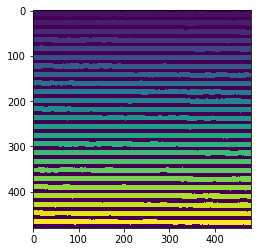

In [9]:
plt.imshow(labels)

In [15]:
print(labels[:,240])

[ 0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  2  2  2
  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  3  3  3  3  3  3  3  3
  3  3  3  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4  4  0  0  0
  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5  5  0  0  0  0  0  0  0  0  6
  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7
  7  7  7  7  0  0  0  0  0  0  0  0  8  8  8  8  8  8  8  8  8  8  8  0  0
  0  0  0  0  0  0  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0
 10 10 10 10 10 10 10 10 10 10 10 10  0  0  0  0  0  0  0 11 11 11 11 11 11
 11 11 11 11 11  0  0  0  0  0  0  0  0 12 12 12 12 12 12 12 12 12 12 12  0
  0  0  0  0  0  0  0 13 13 13 13 13 13 13 13 13 13 13  0  0  0  0  0  0  0
  0 14 14 14 14 14 14 14 14 14 14 14 14  0  0  0  0  0  0  0 15 15 15 15 15
 15 15 15 15 15 15 15  0  0  0  0  0  0  0  0 16 16 16 16 16 16 16 16 16 16
 16  0  0  0  0  0  0  0  0 17 17 17 17 17 17 17 17 17 17 17  0  0  0  0  0
  0  0  0  0

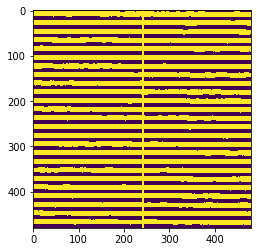

In [13]:
vertical = thresh3

for i in range(0, 480):
    for j in range(240,245):
        if vertical[i,j] == 0:
            vertical[i,j] = 1

new_label = measure.label(vertical)
plt.imshow(new_label)

In [14]:
print(vertical[:,240])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
